# First experiment
Try to let the network learn the flow by using the warped labels as error. In the following we also test, which of the two feature extractors works better for this specific problem. On the one hand, we have the obelisk feature extractor and on the other hand, we have a simple sequential CNN. both have their pros and cons, regarding runtime and used resources.

In [1]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from IPython.display import HTML
import os
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from math import ceil

from utils.preprocessing import preprocessing_flownet, preprocessing_pwc
from utils.load_models import load_flownet2, load_pwcnet, init_weights
from utils.plotting import flow2img, overlaySegment, showFlow
from utils.layers import warp, warpImage #, correlation_layer, meanfield
from utils.encoding import labelMatrixOneHot, dice_coeff


from models.pdd_net.pdd_student import OBELISK2d, deeds2d

In [2]:
# Select a GPU for the work
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
available_gpus = [(torch.cuda.device(i),torch.cuda.get_device_name(i)) for i in range(torch.cuda.device_count())]
available_gpus

[(<torch.cuda.device at 0x7f06d5d318b0>, 'GeForce RTX 2080 Ti')]

# Data

In [3]:
imgs = torch.load('data/train_frames.pth')
segs = torch.load('data/train_segs.pth')

In [4]:
#define a training split 
torch.manual_seed(10)
# Now, we prepare our train & test dataset.
train_set = torch.from_numpy(np.random.choice(np.arange(len(imgs)),size=int(len(imgs)*0.95), replace=False))

test_set = torch.arange(len(imgs))
for idx in train_set:
    test_set = test_set[test_set != idx]


print(f"{train_set.shape[0]} train examples")
print(f"{test_set.shape[0]} test examples")

1135 train examples
60 test examples


# Networks
        

In [5]:
W,H = (150,150)
o_m = H//4
o_n = W//4
ogrid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,o_m,o_n)).view(1,1,-1,2).cuda()
disp_range = 0.25#0.25
displacement_width = 15#15#11#17
shift_xy = F.affine_grid(disp_range*torch.eye(2,3).unsqueeze(0),(1,1,displacement_width,displacement_width)).view(1,1,-1,2).cuda()

grid_size = 32#25#30
grid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,grid_size,grid_size)).view(1,-1,1,2).cuda()


def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
        nn.init.xavier_normal(m.weight)
        if m.bias is not None:
            nn.init.constant(m.bias, 0.0)

class OBELISK2d(nn.Module):
    def __init__(self, chan = 16):

        super(OBELISK2d, self).__init__()
        channels = chan
        self.offsets = nn.Parameter(torch.randn(2,channels *2,2) *0.05)
        self.layer0 = nn.Conv2d(1, 4, 5, stride=2, bias=False, padding=2)
        self.batch0 = nn.BatchNorm2d(4)

        self.layer1 = nn.Conv2d(channels *8, channels *4, 1, bias=False, groups=1)
        self.batch1 = nn.BatchNorm2d(channels *4)
        self.layer2 = nn.Conv2d(channels *4, channels *4, 3, bias=False, padding=1)
        self.batch2 = nn.BatchNorm2d(channels *4)
        self.layer3 = nn.Conv2d(channels *4, channels *1, 1)
        

    def forward(self, input_img):
        img_in = F.avg_pool2d(input_img ,3 ,padding=1 ,stride=2)
        img_in = F.relu(self.batch0(self.layer0(img_in)))
        sampled = F.grid_sample(img_in ,ogrid_xy + self.offsets[0 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)
        sampled -= F.grid_sample(img_in ,ogrid_xy + self.offsets[1 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)

        x = F.relu(self.batch1(self.layer1(sampled)))
        x = F.relu(self.batch2(self.layer2(x)))
        features = self.layer3(x)
        return features
    

In [6]:
def min_convolution(ssd_distance, displace_range, H, W):
    # Prepare operators for smooth dense displacement space
    pad1 = nn.ReplicationPad2d(5)
    avg1 = nn.AvgPool2d(5,stride=1)
    max1 = nn.MaxPool2d(3,stride=1)
    pad2 = nn.ReplicationPad2d(6)
    # approximate min convolution / displacement compatibility

    ssd_minconv = avg1(avg1(-max1(-pad1(ssd_distance.permute(0,2,3,1).reshape(1,-1,displace_range,displace_range)))))

    ssd_minconv = ssd_minconv.permute(0,2,3,1).view(1,-1,H,W)
    min_conv_cost = avg1(avg1(avg1(pad2(ssd_minconv))))
    
    return min_conv_cost

def meanfield(ssd_distance,img_fixed,displace_range,H,W):

    crnt_dev = ssd_distance.device

    cost = min_convolution(ssd_distance, displace_range, H, W)

    soft_cost = F.softmax(-10*cost.view(displace_range**2,-1).t(),1)
    
    disp_hw = (displace_range-1)//2
    disp_mesh_grid = disp_hw*F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,displace_range,displace_range),align_corners=True)
    disp_mesh_grid /= torch.Tensor([(W-1)*.5,(H-1)*.5])

    disp_xy = torch.sum(soft_cost.view(1,H,W,-1,1)*disp_mesh_grid.view(1,1,1,-1,2).to(crnt_dev),3).permute(0,3,1,2) 
    

    return soft_cost,disp_xy

def correlation_layer(displace_range, feat_moving, feat_fixed):
    
    disp_hw = (displace_range-1)//2
    feat_moving_unfold = F.unfold(feat_moving.transpose(1,0),(displace_range,displace_range),padding=disp_hw)
    B,C,H,W = feat_fixed.size()
    
    ssd_distance = ((feat_moving_unfold-feat_fixed.view(C,1,-1))**2).sum(0).view(1,displace_range**2,H,W)

    return ssd_distance

In [7]:
def evaluate_model(model):
    model.eval()
    overall_dice = []
    unwarped_dice = []
    
    for i,idx in enumerate(test_set):
        
        fixed = imgs[idx:idx+1,0,:].unsqueeze(0).float()
        moving = imgs[idx:idx+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[idx:idx+1,0,:].long().contiguous()
        moving_seg = segs[idx:idx+1,1,:].long().contiguous()
        
        # Some images have no segmentation to them, 
        # even if it was present in the directory
        # We leave these ones out, as they cannot be avaluated
        if fixed_seg.max() < 0.1 and moving_seg.max() < 0.1:
            pass
        else:
        
            with torch.no_grad():
                fixed_feat = model(fixed.cuda())
                moving_feat = model(moving.cuda())

            ssd_distance = correlation_layer(displace_range, moving_feat, fixed_feat).contiguous()
            #regularise using meanfield inference with approx. min-convolutions
            soft_cost_one,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
            #upsample field to original resolution
            dense_flow_fit = F.interpolate(disp_xy,size=(H,W),mode='bicubic')


            #apply and evaluate transformation
            identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False).cuda()
            warped_student_seg = F.grid_sample(moving_seg.cuda().float().unsqueeze(1),identity+dense_flow_fit.permute(0,2,3,1),mode='nearest',align_corners=False).cpu()

            d1 = dice_coeff(fixed_seg,warped_student_seg.squeeze(),2)
            d2 = dice_coeff(fixed_seg, moving_seg, 2)
            
            overall_dice.append(d1.mean())
            unwarped_dice.append(d2.mean())
    
    overall_dice = torch.from_numpy(np.array(overall_dice))
    unwarped_dice = torch.from_numpy(np.array(unwarped_dice))
    
    print(f"This model has an average Dice of {round(overall_dice.mean().item(), 5)} mit Variance: {round(overall_dice.var().item(), 5)}. The unwarped Mean dice is: {round(unwarped_dice.mean().item(), 5)} with Var {round(unwarped_dice.var().item(),5)}")

# Training

In [8]:
disp_hw = 5
displace_range = 11

epochs = 100
# minibatch training
grad_accum = 20

In [9]:
obel = OBELISK2d(24)
init_weights(obel)
obel.train().cuda()

optimizer = torch.optim.Adam(list(obel.parameters()),lr=0.0002)

In [10]:
for epoch in range(epochs):

    # Shuffle training examples
    rnd_train_idx = torch.randperm(train_set.size(0))

    # show all examples to model
    for rnd_idx in rnd_train_idx:
        
        p_fix = train_set[rnd_idx]

        # Get image and segmentation
        fixed = imgs[p_fix:p_fix+1,0,:].unsqueeze(0).float()
        moving = imgs[p_fix:p_fix+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[p_fix:p_fix+1,0,:].long().contiguous()
        moving_seg = segs[p_fix:p_fix+1,1,:].long().contiguous()

        # Downsize the label
        C1,Hf,Wf = moving_seg.size()
        label_moving = F.one_hot(moving_seg,num_classes=2).permute(0,3,1,2).float()
        label_moving = F.interpolate(label_moving,size=(Hf//4,Wf//4),mode='bilinear')
        
        label_fixed = F.one_hot(fixed_seg,num_classes=2).permute(0,3,1,2).float()
        label_fixed = F.interpolate(label_fixed,size=(Hf//4,Wf//4),mode='bilinear')
        # generate the "unfolded" version of the moving encoding that will result in the shifted versions per channel
        # according to the corresponding discrete displacement pair
        label_moving_unfold = F.unfold(label_moving,(displace_range,displace_range),padding=disp_hw).view(1,2,displace_range**2,-1)

        # passed through obelisk layer
        feat00 = obel(fixed.cuda())      # fixed
        feat50 = obel(moving.cuda())     # moving

         # compute the cost tensor using the correlation layer
        ssd_distance = correlation_layer(displace_range, feat50, feat00)

        # compute the MIN-convolution & probabilistic output with the given function
        soft_cost,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
        
        label_warped = torch.sum(soft_cost.cpu().t().unsqueeze(0)*label_moving_unfold.squeeze(0),1)
        # compute the loss as sum of squared differences between the fixed label representation and the "warped" labels

        label_distance1 = torch.sum(torch.pow(label_fixed.reshape(2,-1)-label_warped.reshape(2,-1),2),0)
        loss = label_distance1.mean()
        # perform the backpropagation and weight updates
        loss.backward()

        #diffs.append(loss.item())
        if (epoch+1)%grad_accum == 0:
            # every grad_accum iterations : backpropagate the accumulated gradients
            optimizer.step()
            optimizer.zero_grad()

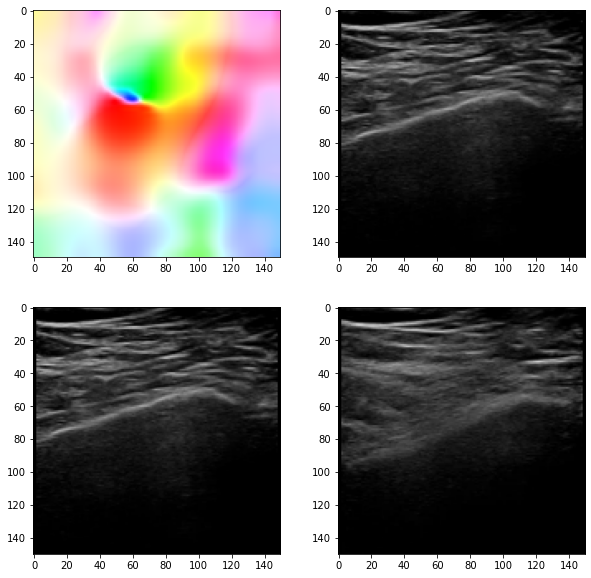

In [11]:
obel.eval()

rnd_test_idx = torch.randperm(test_set.size(0))
p_fix = test_set[rnd_test_idx[0]]

fixed = imgs[p_fix:p_fix+1,0,:].unsqueeze(0).float()
moving = imgs[p_fix:p_fix+1,1,:].unsqueeze(0).float()

fixed_seg = segs[p_fix:p_fix+1,0,:].long().contiguous()
moving_seg = segs[p_fix:p_fix+1,1,:].long().contiguous()

#flow_in = preprocessing_flownet(fixed.reshape(H,W,1),moving.reshape(H,W,1)).cuda()
#teacher_flow = flow2(flow_in)

with torch.no_grad():
    fixed_feat = obel(fixed.cuda())
    moving_feat = obel(moving.cuda())

ssd_distance = correlation_layer(displace_range, moving_feat, fixed_feat).contiguous()
#regularise using meanfield inference with approx. min-convolutions
soft_cost_one,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
#upsample field to original resolution
dense_flow_fit = F.interpolate(disp_xy,size=(H,W),mode='bicubic')


#apply and evaluate transformation
identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False).cuda()
warped_student_seg = F.grid_sample(moving_seg.cuda().float().unsqueeze(1),identity+dense_flow_fit.permute(0,2,3,1),mode='nearest',align_corners=False).cpu()

#warped_teacher_seg = warp(moving_seg.unsqueeze(0).float().cuda(),teacher_flow.squeeze().cuda()).cpu()

d1 = dice_coeff(fixed_seg,warped_student_seg.squeeze(),2)
d0 = dice_coeff(fixed_seg,moving_seg,2)

rgb = showFlow(dense_flow_fit.cpu().transpose(-2,-1).flip(1))
overlay = overlaySegment(fixed.squeeze(),warped_student_seg.data.squeeze(),False)

overlay_fixed = overlaySegment(fixed.squeeze(),fixed_seg.data.squeeze(),False)
overlay_moving = overlaySegment(moving.squeeze(),moving_seg.data.squeeze(),False)

fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(rgb)
plt.subplot(222)
plt.imshow(overlay)

plt.subplot(223)
plt.imshow(overlay_fixed)
plt.subplot(224)
plt.imshow(overlay_moving)

## Sequential

In [12]:
seq = torch.nn.Sequential(torch.nn.Conv2d(1,32,kernel_size=5,stride=2,padding=4,dilation=2),
                          torch.nn.BatchNorm2d(32),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(32,32,kernel_size=3,stride=1,padding=1,dilation=1),
                          torch.nn.BatchNorm2d(32),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(32,64,kernel_size=3,stride=2,padding=0,dilation=1),
                          torch.nn.BatchNorm2d(64),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(64,24,kernel_size=1,stride=1,padding=0,dilation=1),
                          torch.nn.Sigmoid())
seq.train().cuda()
optimizer = torch.optim.Adam(list(seq.parameters()),lr=0.0002)

In [13]:
for epoch in range(epochs):

   # Shuffle training examples
    rnd_train_idx = torch.randperm(train_set.size(0))

    # show all examples to model
    for rnd_idx in rnd_train_idx:
        
        p_fix = train_set[rnd_idx]

        # Get image and segmentation
        fixed = imgs[p_fix:p_fix+1,0,:].unsqueeze(0).float()
        moving = imgs[p_fix:p_fix+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[p_fix:p_fix+1,0,:].long().contiguous()
        moving_seg = segs[p_fix:p_fix+1,1,:].long().contiguous()

        # Downsize the label
        C1,Hf,Wf = moving_seg.size()
        label_moving = F.one_hot(moving_seg,num_classes=2).permute(0,3,1,2).float()
        label_moving = F.interpolate(label_moving,size=(Hf//4,Wf//4),mode='bilinear')
        
        label_fixed = F.one_hot(fixed_seg,num_classes=2).permute(0,3,1,2).float()
        label_fixed = F.interpolate(label_fixed,size=(Hf//4,Wf//4),mode='bilinear')
        # generate the "unfolded" version of the moving encoding that will result in the shifted versions per channel
        # according to the corresponding discrete displacement pair
        label_moving_unfold = F.unfold(label_moving,(displace_range,displace_range),padding=disp_hw).view(1,2,displace_range**2,-1)

        # passed through obelisk layer
        feat00 = seq(fixed.cuda())      # fixed
        feat50 = seq(moving.cuda())     # moving

         # compute the cost tensor using the correlation layer
        ssd_distance = correlation_layer(displace_range, feat50, feat00)

        # compute the MIN-convolution & probabilistic output with the given function
        soft_cost,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
        
        label_warped = torch.sum(soft_cost.cpu().t().unsqueeze(0)*label_moving_unfold.squeeze(0),1)
        # compute the loss as sum of squared differences between the fixed label representation and the "warped" labels

        label_distance1 = torch.sum(torch.pow(label_fixed.reshape(2,-1)-label_warped.reshape(2,-1),2),0)
        loss = label_distance1.mean()
        # perform the backpropagation and weight updates
        loss.backward()

        #diffs.append(loss.item())
        if (epoch+1)%grad_accum == 0:
            # every grad_accum iterations : backpropagate the accumulated gradients
            optimizer.step()
            optimizer.zero_grad()

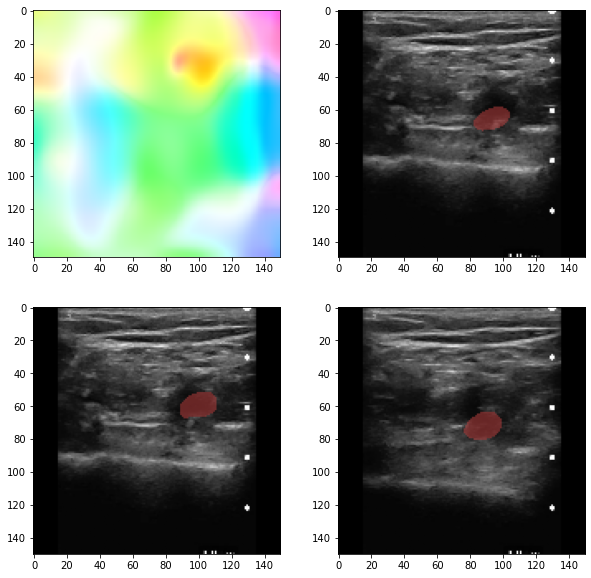

In [14]:
seq.eval()

rnd_test_idx = torch.randperm(test_set.size(0))
p_fix = test_set[rnd_test_idx[0]]

fixed = imgs[p_fix:p_fix+1,0,:].unsqueeze(0).float()
moving = imgs[p_fix:p_fix+1,1,:].unsqueeze(0).float()

fixed_seg = segs[p_fix:p_fix+1,0,:].long().contiguous()
moving_seg = segs[p_fix:p_fix+1,1,:].long().contiguous()

#flow_in = preprocessing_flownet(fixed.reshape(H,W,1),moving.reshape(H,W,1)).cuda()
#teacher_flow = flow2(flow_in)

with torch.no_grad():
    fixed_feat = obel(fixed.cuda())
    moving_feat = obel(moving.cuda())

ssd_distance = correlation_layer(displace_range, moving_feat, fixed_feat).contiguous()
#regularise using meanfield inference with approx. min-convolutions
soft_cost_one,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
#upsample field to original resolution
dense_flow_fit = F.interpolate(disp_xy,size=(H,W),mode='bicubic')


#apply and evaluate transformation
identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False).cuda()
warped_student_seg = F.grid_sample(moving_seg.cuda().float().unsqueeze(1),identity+dense_flow_fit.permute(0,2,3,1),mode='nearest',align_corners=False).cpu()

#warped_teacher_seg = warp(moving_seg.unsqueeze(0).float().cuda(),teacher_flow.squeeze().cuda()).cpu()

d1 = dice_coeff(fixed_seg,warped_student_seg.squeeze(),2)
d0 = dice_coeff(fixed_seg,moving_seg,2)

rgb = showFlow(dense_flow_fit.cpu().transpose(-2,-1).flip(1))
overlay = overlaySegment(fixed.squeeze(),warped_student_seg.data.squeeze(),False)

overlay_fixed = overlaySegment(fixed.squeeze(),fixed_seg.data.squeeze(),False)
overlay_moving = overlaySegment(moving.squeeze(),moving_seg.data.squeeze(),False)

fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(rgb)
plt.subplot(222)
plt.imshow(overlay)

plt.subplot(223)
plt.imshow(overlay_fixed)
plt.subplot(224)
plt.imshow(overlay_moving)

# Comparisson


In [15]:
print("Obelisk:")
evaluate_model(obel)
print("Sequential:")
evaluate_model(seq)

Obelisk:
This model has an average Dice of 0.81798 mit Variance: 0.02356. The unwarped Mean dice is: 0.77513 with Var 0.04216
Sequential:
This model has an average Dice of 0.75594 mit Variance: 0.02773. The unwarped Mean dice is: 0.77513 with Var 0.04216


## Baseline

In [18]:
baseline = cv2.optflow.DualTVL1OpticalFlow_create()
overall_dice = []

for i,idx in enumerate(test_set):
        
        fixed = imgs[idx:idx+1,0,:].unsqueeze(0).float()
        moving = imgs[idx:idx+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[idx:idx+1,0,:].long().contiguous()
        moving_seg = segs[idx:idx+1,1,:].long().contiguous()
        
        # Some images have no segmentation to them, 
        # even if it was present in the directory
        # We leave these ones out, as they cannot be avaluated
        if fixed_seg.max() < 0.1 and moving_seg.max() < 0.1:
            pass
        else:
            in1 = fixed.view(H,W,1).numpy().astype(np.float32)
            in2 = moving.view(H,W,1).numpy().astype(np.float32)
            flow = baseline.calc(in1,in2,None)
            
            #warped_seg = warpImage(moving_seg.view(1,1,H,W).float(), torch.from_numpy(flow).view(1,2,H,W))
            warped_seg = warp(moving_seg.float().unsqueeze(0).cuda(), torch.from_numpy(flow).view(2,H,W).unsqueeze(0).cuda()).cpu().to(torch.int64)
            
            overall_dice.append(dice_coeff(fixed_seg,warped_seg.squeeze(),2).mean())
overall_dice = torch.from_numpy(np.array(overall_dice))
print(f"Baseline reacher a mean dice score of {rount(overall_dice.mean().item(),5)} with Var of {round(overall_dice.var().item(),5)}")

Baseline reacher a mean dice score of 0.7536314129829407 with Var of 0.03941921517252922


# Verdcit
Over the run of 100 epochs, with an adam optimizer and a learning rate of 0.0002, the Obelisk feature extractor outperforms the sequential model, when looking at the mean dice score and dice score variance. This is why we will consider the obelisk feature extractor from now on, as it seems to have an adjvantage over a simple sequential model, when it comes to processing Ultrasound images.

|Model|Mean Dice|Dice Var|
| --- | --- | --- |
|*Unwarped*|*0.77513*|*0.04216*|
|Baseline|0.7536|0.03941|
|**Obelisk** |**0.81798**|**0.02356**|
|Sequential|0.75594|0.02773| 


## Next
Next we will try to use a relatively simple student teacher approach, in order to give in more information to the feature extractor, which could lead to better performance.